In [1]:
import dreye
import numpy as np
import pandas as pd
import seaborn as sns

## Get dummy LED measurements and a photoreceptor model

In [2]:
wls = np.arange(300, 651)

In [3]:
np.random.seed(10)
peaks = np.linspace(350, 580, 7)
leds = dreye.create_gaussian_spectrum(
    wls, 
    peaks, 
    (np.random.random(peaks.size) + 0.3) * 10
)

In [4]:
intensity_bounds=(
    np.zeros(peaks.size), 
    (np.random.random(peaks.size) + 0.5) * 10
)
measured_spectra = dreye.get_led_spectra_container(
    leds,
    names=['duv', 'uv', 'violet', 'blue', 'cyan', 'green', 'amber'], 
    intensity_bounds=intensity_bounds, 
    output_bounds=(0, 5)
)

## Spectra of LEDs used for fitting

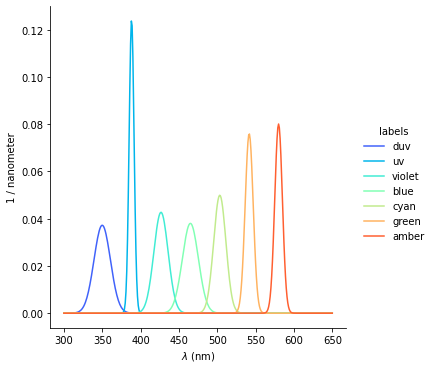

In [5]:
measured_spectra.normalized_spectra.plot(palette='rainbow')

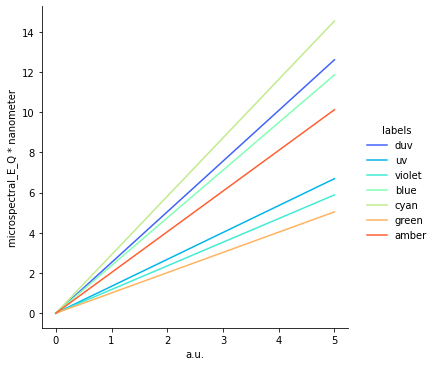

In [6]:
measured_spectra.intensities.plot(palette='rainbow')

In [7]:
# intensity range of LEDs
measured_spectra.intensity_bounds

(array([0., 0., 0., 0., 0., 0., 0.]),
 array([12.60530712,  6.69110837,  5.88339814, 11.85359818, 14.53393346,
         5.03948266, 10.12192263]))

## Trichromatic linear photoreceptor model

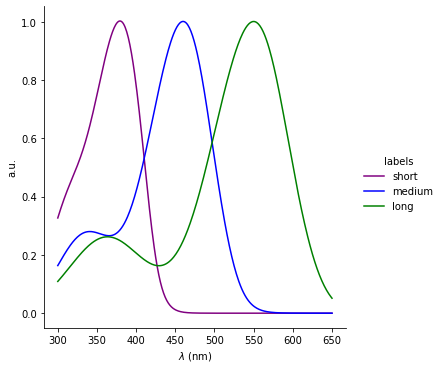

In [8]:
cmap = {'short': 'purple', 'medium': 'blue', 'long': 'green'}

sensitivity = dreye.Sensitivity(
    np.array([380, 460, 550]), 
    wls, 
    from_template=True, 
    labels=list(cmap), 
    name='opsins'
)
sensitivity.plot(palette=cmap)

photoreceptor_model = dreye.LinearPhotoreceptor(sensitivity)

In [9]:
from sklearn.decomposition import PCA
model = PCA(len(cmap))
model.fit(sensitivity.magnitude)

PCA(n_components=3)

In [10]:
model.components_

array([[-0.69234446, -0.3793454 ,  0.61380471],
       [-0.55503906,  0.82354185, -0.11709166],
       [-0.46107568, -0.42175335, -0.78072615]])

In [11]:
metrics = dreye.MeasuredSpectraMetrics([3, 4], photoreceptor_model, measured_spectra)

In [72]:
def get_polar(X):
    CX = X @ model.components_[:, 1:]
    assert CX.shape[1] == 2
    sat = np.linalg.norm(CX, axis=-1)
    hue = np.arctan2(CX[:, 0], CX[:, 1])
    return np.array([sat, hue]).T

def get_saturation(X):
    return get_polar(X)[:, 0]

def get_hue(X):
    return get_polar(X)[:, 1]

def get_normalized(X):
    CX = X @ model.components_[:, 1:]
    return CX / np.linalg.norm(CX, axis=-1)[..., None]

In [73]:
Bs = {
    'prs': np.eye(len(cmap)),
    'achromatic': model.components_[:, :1], 
    'chromatic': model.components_[:, 1:], 
    'saturation': get_saturation, 
    'hue': get_hue, 
    'normalized': get_normalized
}

In [74]:
df = metrics.get_excitation_volumes(Bs)
df = df[df['transformation'] != 'hue']
df_hue = metrics.get_excitation_continuities(
    Bs['hue'], bins=1000, range=(-np.pi, np.pi)
)
df_hue['transformation'] = 'hue'
df = pd.concat([df, df_hue])

In [75]:
df.sort_values('metric', ascending=False).head()

,duv,uv,violet,blue,cyan,green,amber,metric,light_combos,k,metric_name,transformation
209,False,False,False,True,True,True,True,1.0,blue+cyan+green+amber,4,volume,chromatic
279,False,False,False,True,True,True,True,1.0,blue+cyan+green+amber,4,volume,saturation
367,False,True,True,False,False,True,False,1.0,uv+violet+green,3,volume,normalized
52,True,False,False,True,True,False,True,1.0,duv+blue+cyan+amber,4,volume,prs
109,True,True,False,True,True,False,False,1.0,duv+uv+blue+cyan,4,volume,achromatic


In [76]:
def get_largest_volumes(df, transformation=None):
    if transformation is not None:
        df1 = df[df['transformation'] == transformation]
    else:
        df1 = df
    df2 = df1.groupby(['light_combos'])[['metric', 'k']].mean().groupby('k')['metric'].nlargest(3)
    return pd.merge(df2.reset_index()[['k', 'light_combos']], df)
largest_volumes = get_largest_volumes(df)
largest_by_chromatic = get_largest_volumes(df, 'chromatic')
largest_by_achromatic = get_largest_volumes(df, 'achromatic')
largest_by_prs = get_largest_volumes(df, 'prs')
largest_by_saturation = get_largest_volumes(df, 'saturation')
largest_by_hue = get_largest_volumes(df, 'hue')

In [77]:
largest_volumes.head()

,k,light_combos,duv,uv,violet,blue,cyan,green,amber,metric,metric_name,transformation
0,3,duv+blue+cyan,True,False,False,True,True,False,False,0.396996,volume,prs
1,3,duv+blue+cyan,True,False,False,True,True,False,False,0.837350,volume,achromatic
2,3,duv+blue+cyan,True,False,False,True,True,False,False,0.421079,volume,chromatic
3,3,duv+blue+cyan,True,False,False,True,True,False,False,0.749557,volume,saturation
4,3,duv+blue+cyan,True,False,False,True,True,False,False,0.999904,volume,normalized


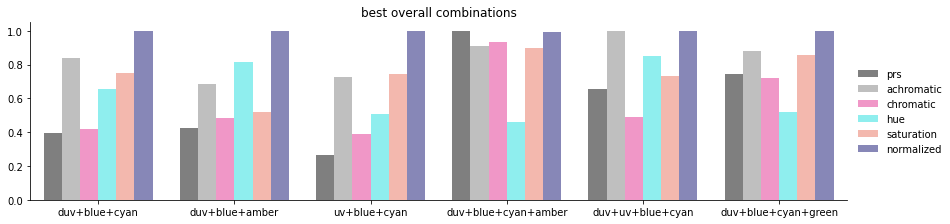

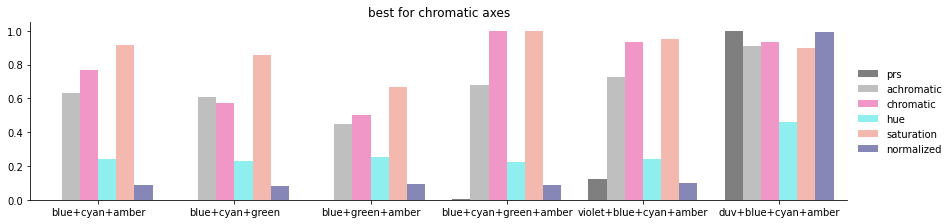

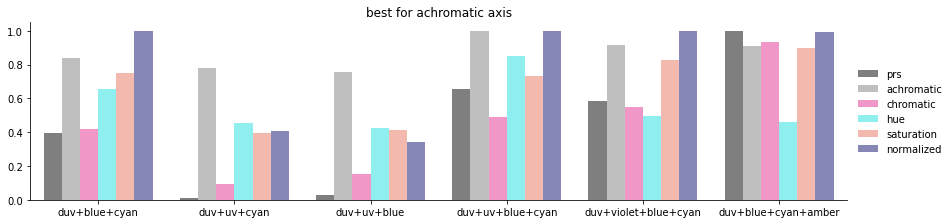

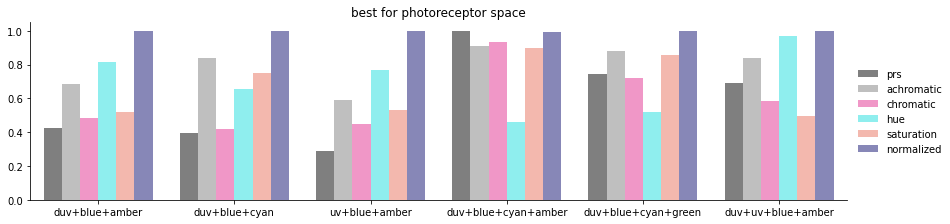

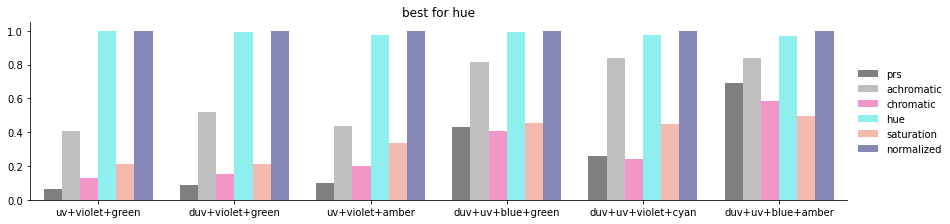

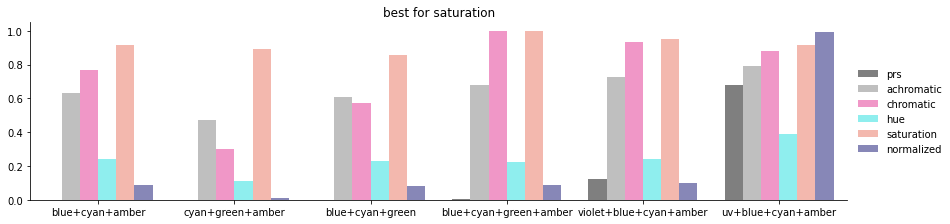

In [78]:
def plot_largest_volumes(df, title=''):
    g = sns.FacetGrid(
        data=df, 
        sharex=False,
        aspect=4
    )

    g.map_dataframe(
        sns.barplot, 
        x='light_combos', 
        y='metric', 
        hue='transformation',
        alpha=0.5, 
        palette={
            'achromatic': 'gray', 
            'prs': 'black', 
            'chromatic': 'deeppink', 
            'hue': 'cyan', 
            'saturation': 'tomato', 
            'polar': 'gold', 
            'normalized': 'navy'
        },
        hue_order=['prs', 'achromatic', 'chromatic', 'hue', 'saturation', 'normalized']
    ).add_legend()
    for ax in g.axes.ravel():
        ax.set_title(title)
    
plot_largest_volumes(largest_volumes, 'best overall combinations')
plot_largest_volumes(largest_by_chromatic, 'best for chromatic axes')
plot_largest_volumes(largest_by_achromatic, 'best for achromatic axis')
plot_largest_volumes(largest_by_prs, 'best for photoreceptor space')
plot_largest_volumes(largest_by_hue, 'best for hue')
plot_largest_volumes(largest_by_saturation, 'best for saturation')

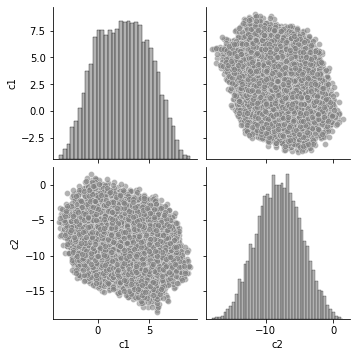

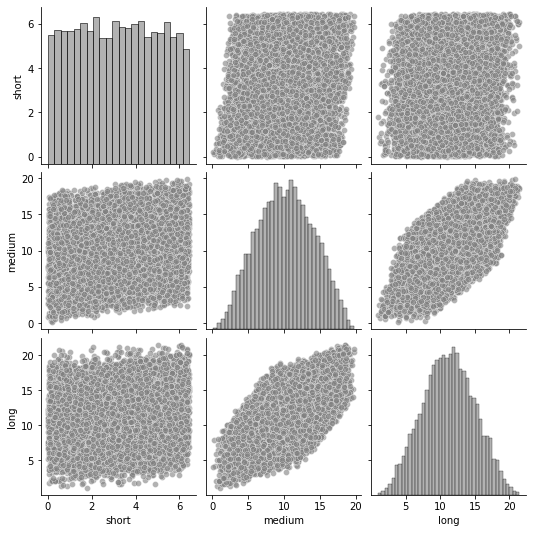

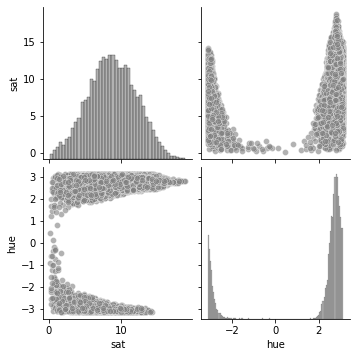

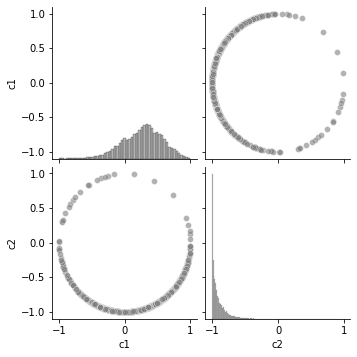

In [81]:
light_combo = 'uv+blue+cyan+amber'

sns.pairplot(
    data=pd.DataFrame(
        metrics.get_excitations(light_combo) @ Bs['chromatic'], 
        columns=['c1', 'c2']
    ), 
    plot_kws=dict(
        color='gray', 
        alpha=0.6
    ),
    diag_kws=dict(
        color='gray', 
        alpha=0.6
    )
)
sns.pairplot(
    data=pd.DataFrame(
        metrics.get_excitations(light_combo),
        columns=list(cmap)
    ), 
    plot_kws=dict(
        color='gray', 
        alpha=0.6
    ),
    diag_kws=dict(
        color='gray', 
        alpha=0.6
    )
)
sns.pairplot(
    data=pd.DataFrame(
        get_polar(metrics.get_excitations(light_combo)),
        columns=['sat', 'hue']
    ), 
    plot_kws=dict(
        color='gray', 
        alpha=0.6
    ),
    diag_kws=dict(
        color='gray', 
        alpha=0.6
    )
)
sns.pairplot(
    data=pd.DataFrame(
        get_normalized(metrics.get_excitations(light_combo)),
        columns=['c1', 'c2']
    ), 
    plot_kws=dict(
        color='gray', 
        alpha=0.6
    ),
    diag_kws=dict(
        color='gray', 
        alpha=0.6
    )
)